## Input parameters


In [1]:
# tanyaMay24-trainset70shuffle2  -  DeepCut_resnetresnet_50_70shuffle2_130000forTask:tanya
#snapshot-130000

snapshot =  'snapshot-130000'

shuffleIndex =  2

trainFractionIndex =  0  #int(sys.argv[3])

test_images_path = '/is/ps2/calvarez2/DeepLabCut/test_images/images'
labeled_images_path = '/is/ps2/calvarez2/DeepLabCut/test_images/labeled_images'

max_input_size = 1000.0

## -------------------

In [2]:
"""
Camila modification --

DeepLabCut Toolbox
https://github.com/AlexEMG/DeepLabCut
A Mathis, alexander.mathis@bethgelab.org
M Mathis, mackenzie@post.harvard.edu
This script evaluates a trained model at a particular state on the data set (images)
and stores the results in a pandas dataframe.
Script called from Step1_EvaluateModelonDataset.py
"""

import sys
import os
subfolder = os.getcwd().split('Evaluation-Tools')[0]
sys.path.append(subfolder)


# add parent directory: (where nnet & config are!)
sys.path.append(subfolder + "pose-tensorflow")
sys.path.append(subfolder + "Generating_a_Training_Set")

from myconfig import Task, date, Shuffles, scorer, TrainingFraction,snapshotindex

# Deep-cut dependencies
from config import load_config
from nnet import predict
from dataset.pose_dataset import data_to_input

# Dependencies for anaysis
import pickle
import skimage
import numpy as np
import pandas as pd
from skimage import io
import skimage.color
import auxiliaryfunctions
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2


print("Starting evaluation") #, sys.argv)

Starting evaluation


In [3]:
shuffle=Shuffles[shuffleIndex]
trainFraction=TrainingFraction[trainFractionIndex]

basefolder = os.path.join('..','pose-tensorflow','models')
folder = os.path.join('UnaugmentedDataSet_' + Task + date)

In [4]:
#######################################################################
# Load and setup CNN part detector as well as its configuration
#######################################################################

experimentname = Task + date + '-trainset' + str(int(trainFraction * 100)) + 'shuffle' + str(shuffle)
cfg = load_config(os.path.join(basefolder , experimentname , 'test' ,"pose_cfg.yaml"))
modelfolder = os.path.join(basefolder, experimentname)

cfg['init_weights'] = os.path.join(modelfolder,'train',snapshot)

trainingsiterations = (
    cfg['init_weights'].split('/')[-1]).split('-')[-1]
DLCscorer = 'DeepCut' + "_resnet" + str(cfg["net_type"]) + "_" + str(
    int(trainFraction *
        100)) + 'shuffle' + str(shuffle) + '_' + str(trainingsiterations) + "forTask:" + Task

print("Running ", DLCscorer, " with # of trainingiterations:", trainingsiterations)


('Running ', 'DeepCut_resnetresnet_50_70shuffle2_130000forTask:tanya', ' with # of trainingiterations:', '130000')


In [5]:
try:
    Data = pd.read_hdf(os.path.join("Results",DLCscorer + '.h5'),'df_with_missing')
    print("This net has already been evaluated!")
except :
    # Specifying state of model (snapshot / training state)
    cfg['init_weights'] = os.path.join(modelfolder,'train',snapshot)
    
    sess, inputs, outputs = predict.setup_pose_prediction(cfg)
    
    
    images_names = os.listdir(test_images_path)
    
    Numimages = len(images_names) #len(Data.index)
    PredicteData = np.zeros((Numimages,3 * len(cfg['all_joints_names'])))
    Testset = np.zeros(Numimages)
    
    print("Analyzing data...")
    
    ##################################################
    # Compute predictions over images
    ##################################################
    
    for imageindex, imagename in tqdm(enumerate(images_names)):
        image = io.imread(os.path.join(test_images_path, imagename),mode='RGB')
        image = skimage.color.gray2rgb(image)
        height, width, channels = image.shape
        if(width * height > max_input_size*max_input_size):
                factor = (max_input_size*0.9)/max(height, width)
                image = cv2.resize(image, None, fx = factor, fy = factor, interpolation = cv2.INTER_CUBIC)
        
        image_batch = data_to_input(image)
        
        
        # Compute prediction with the CNN
        outputs_np = sess.run(outputs, feed_dict={inputs: image_batch})
        scmap, locref = predict.extract_cnn_output(outputs_np, cfg)
        
        # Extract maximum scoring location from the heatmap, assume 1 person
        pose = predict.argmax_pose_predict(scmap, locref, cfg.stride)
        PredicteData[imageindex, :] = pose.flatten(
        )  # NOTE: thereby     cfg_test['all_joints_names'] should be same order as bodyparts!
      
        index = pd.MultiIndex.from_product(
            [[DLCscorer], cfg['all_joints_names'], ['x', 'y', 'likelihood']],
            names=['scorer', 'bodyparts', 'coords'])

        # Saving results:
        auxiliaryfunctions.attempttomakefolder("Results")

        DataMachine = pd.DataFrame(
            PredicteData, columns=index, index= images_names )
        DataMachine.to_hdf(os.path.join("Results",'Test_sample_'+DLCscorer + '.h5'),'df_with_missing',format='table',mode='w')
        print("Done and results stored for snapshot: ", snapshot)        

        

Instructions for updating:
Pass is_training directly to the network instead of the arg_scope.


Instructions for updating:
Pass is_training directly to the network instead of the arg_scope.


INFO:tensorflow:Restoring parameters from ../pose-tensorflow/models/tanyaMay24-trainset70shuffle2/train/snapshot-130000


INFO:tensorflow:Restoring parameters from ../pose-tensorflow/models/tanyaMay24-trainset70shuffle2/train/snapshot-130000
0it [00:00, ?it/s]

Analyzing data...


1it [00:00,  2.17it/s]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


2it [00:03,  1.55s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


3it [00:05,  1.90s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


4it [00:09,  2.26s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


5it [00:11,  2.33s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


6it [00:14,  2.34s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


7it [00:16,  2.36s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


8it [00:19,  2.46s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


9it [00:20,  2.29s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


10it [00:24,  2.45s/it]

Folder already exists!
('Done and results stored for snapshot: ', 'snapshot-130000')


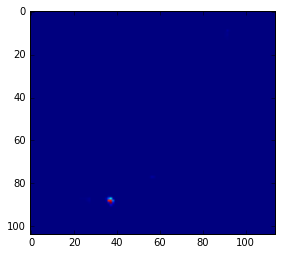

In [6]:
#score-map example

plt.imshow(scmap[:,:,-1])#.shape

In [7]:
DataMachine

scorer          DeepCut_resnetresnet_50_70shuffle2_130000forTask:tanya  \
bodyparts                                                     tail tip   
coords                                                               x   
download.jpeg                                           245.382314       
frame00.png                                             409.653399       
frame016.png                                            345.447286       
download_1.jpeg                                         182.991818       
frame012.png                                            250.050287       
frame018.png                                            417.062585       
frame068.png                                            279.147069       
down_3.jpeg                                             195.184207       
down_2.jpg                                               65.970319       
down_4.jpg                                              149.593805       

scorer                                                                  \
bodyparts                              back right shoulder               
coords                    y likelihood                   x           y   
download.jpeg    100.015515   0.265371          185.128764   74.701450   
frame00.png      344.335858   0.986123          443.690578  329.763583   
frame016.png     437.938697   0.801735          456.827526  376.762305   
download_1.jpeg  129.773888   0.004649          581.161187  368.587718   
frame012.png     407.790377   0.993865          360.458509  370.573653   
frame018.png     404.873542   0.999113          429.932432  334.674239   
frame068.png     385.129313   0.991591          361.292077  343.213976   
down_3.jpeg      405.002849   0.758334          255.898964  299.718558   
down_2.jpg       280.404029   0.777394          123.080457  221.616029   
down_4.jpg       515.811413   0.999925          188.280128  389.325397   

scorer                                                                         \
bodyparts                   tail start                        front left knee   
coords          likelihood           x           y likelihood               x   
download.jpeg     0.395936  223.865395   50.322141   0.096255      121.818413   
frame00.png       0.985115  419.713851  300.987462   0.985115      487.435946   
frame016.png      0.351175  389.137238  273.189516   0.999952      711.372273   
download_1.jpeg   0.133978  489.237836  203.015869   0.047165      314.874006   
frame012.png      0.384293  282.977425  307.040379   0.998956      554.278966   
frame018.png      0.977192  416.980121  292.802114   0.168163      603.450896   
frame068.png      0.299136  310.241287  309.044729   0.999852      450.966579   
down_3.jpeg       0.124055  185.465981  200.396163   0.898119      470.233615   
down_2.jpg        0.962826   83.110968  167.793928   0.878578      272.421529   
down_4.jpg        0.938528  127.756202  257.835569   0.201454      543.183699   

scorer             ...                                                 \
bodyparts          ...     back right foot back left knee               
coords             ...          likelihood              x           y   
download.jpeg      ...            0.118286     231.784287  113.234203   
frame00.png        ...            0.993838     436.571661  359.365819   
frame016.png       ...            0.243947     426.258570  455.421768   
download_1.jpeg    ...            0.021963     308.864642  510.295026   
frame012.png       ...            0.668956     550.045852  439.395160   
frame018.png       ...            0.910618     460.396295  421.092993   
frame068.png       ...            0.334986     318.325034  408.406431   
down_3.jpeg        ...            0.048603     217.569190  432.552882   
down_2.jpg         ...            0.324584      91.617234  265.511842   
down_4.jpg         ...            0.002149     441.173550  589.662492   

scorer                                                                

In [8]:
DLCscorer

'DeepCut_resnetresnet_50_70shuffle2_130000forTask:tanya'

# --- Store visualization of keypoints ----


In [9]:
import os.path
import sys
#sys.path.append(os.getcwd().split('Generating_a_Training_Set')[0])


from skimage import io
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [5,3]
from myconfig import Task, filename, bodyparts, Scorers
from myconfig import scorer as cfg_scorer

Labels = ['.', '+', '*']  # order of labels for different scorers

# https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
Colorscheme = get_cmap(len(bodyparts))

comparisonbodyparts = list(set(DataMachine.columns.get_level_values(1)))

scale = 1  # for plotting
msize = 15   #size of labels

scorer_machine = DLCscorer

thr_likelihood = 0.1  #likelihood > 10 %

In [10]:
# imagename = 'frame016.png' #'download_1.jpeg.jpeg' #'frame016.png'  #'frame016.png'

for imageindex, imagename in tqdm(enumerate(images_names)):


    imindex = np.where(
                np.array(DataMachine.index.values) == imagename)[0]

    # image = io.imread('/is/ps2/calvarez2/DeepLabCut/pose-tensorflow/models/UnaugmentedDataSet_tanyaMay24/data-tanya/' + imagename)
    image = io.imread(os.path.join(test_images_path, imagename),mode='RGB')
    image = skimage.color.gray2rgb(image) 
    height, width, channels = image.shape
    if(width * height > max_input_size*max_input_size):
        factor = (max_input_size*0.9)/max(height, width)## To Define: img name
        image = cv2.resize(image, None, fx = factor, fy = factor, interpolation = cv2.INTER_CUBIC)
    
    plane_name , extenstion = imagename.split('.')

    if extenstion != 'png':
        imagename = plane_name + '.png'


    plt.axis('off')

    if np.ndim(image)==2:
        h, w = np.shape(image)
    else:
        h, w, nc = np.shape(image)

    plt.figure(
        frameon=False, figsize=(w * 1. / 100 * scale, h * 1. / 100 * scale))
    plt.subplots_adjust(
        left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    plt.imshow(image, 'bone')
    for cc, scorer in enumerate(Scorers):
        for c, bp in enumerate(comparisonbodyparts):
            
            #cheeck likelihood > thr_likelihood %
            
            if (DataMachine[scorer_machine][bp]['likelihood'].values[imindex] > thr_likelihood):

                plt.plot(   
                        DataMachine[scorer_machine][bp]['x'].values[imindex],
                        DataMachine[scorer_machine][bp]['y'].values[imindex],
                        Labels[0],
                        color=Colorscheme(c),
                        alpha=.5,
                        ms=msize)
            else:
                
                plt.plot(   
                        DataMachine[scorer_machine][bp]['x'].values[imindex],
                        DataMachine[scorer_machine][bp]['y'].values[imindex],
                        Labels[-1],
                        color='w',
                        alpha=.5,
                        ms=msize)
                
            
            
    

    plt.xlim(0, w)
    plt.ylim(0, h)
    plt.axis('off')
    plt.subplots_adjust(
        left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.gca().invert_yaxis()
    plt.savefig(labeled_images_path + '/' + imagename , dpi=100) #dpi=100 = original size
    plt.close("all")
    
    



10it [00:05,  1.72it/s]
